<a href="https://colab.research.google.com/github/PHYS486-S22/PHYS486-S22/blob/main/SampleNotebooks/ProjectTwo_Relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the usual imports


In [63]:
#import numpy, scipy, and math libraries
import numpy as np
import math

#import matplotlib so that we can make plots; import common subroutines and give them compact names
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

# Relaxation method functions

First, a generic function to perform one relaxation step over an input grid of arbitrary size

In [92]:
#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def loopCells(grid, finishGrid, dimensions, charges = None):
 
    #use two loops to loop over rows and columns
    for i in range(1,dimensions[0]-1):
        for j in range(1,dimensions[1]-1):
            #print(i,j, grid[i,j])

            if (np.any(charges) != 0.):
                if (charges[i,j] != 0.):
                  finishGrid[i,j] = charges[i,j]
                else:
                  finishGrid[i,j] = 0.25 * (grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )
            else:
                finishGrid[i,j] = 0.25 * ( grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )
 
    return finishGrid

Now, a slightly less generic funtion that relaxes a grid until it meets an input (relative estimated) error criteria, and allows for inserting charges into the grid (ie, imposes boundary conditions inside as well as outside of the grid).

In [93]:
#write a function that relaxes a 2-D grid until a final error Criteria is reached
def relaxGrid(grid, errorCriteria, limit = None, local = None, charges = None):
    
    #find the size of the array
    dimensions = grid.shape

    #copy the grid into a second array so we can populate without replacement
    #NOTE -- this is important, because if we don't do it, we'll accidentally 
    #be implementing the Gauss-Seidel method because of the way that python
    #defaults to referencing variables rather than creating brand new instances!!!
    finishGrid = np.copy(grid)
    
    #initialize trackers for the number of iterations performed
    #and the average change per site
    errorTracker = 100*errorCriteria
    iterations = 0
    
    #set the limit on the minimum number of iterations to perform
    if (limit == None):
        useLimit = 5*dimensions[0]
    else:
        useLimit = limit
    
    #enter the while loop if the change per site is less than the convergence criteria
    while (errorTracker > errorCriteria):
        
        #increase our iteration counter
        iterations = iterations+1

        #iterate our relaxation method forward one step; store the answer in finishGrid, our copy 
        #of the original grid that was passed to the function.
        if (np.any(charges) != 0):
            finishGrid = loopCells(grid, finishGrid, dimensions, charges = charges)
        else:            
            finishGrid = loopCells(grid, finishGrid, dimensions)
        
        #test if we've passed our minimum number of iterations.  If so, calculate a genuine
        #value of errorTracker; if not, continue to use our inflated value.
        if (iterations > useLimit):
            errorTracker = np.sum( np.absolute(grid[1:dimensions[0]-2,1:dimensions[1]-2] - finishGrid[1:dimensions[0]-2,1:dimensions[1]-2] ))/( (dimensions[0]-2)*(dimensions[1]-2) )
        else:
            errorTracker = errorCriteria*100

        #check if the average change per site (which is only a real number if we've satisified our 
        #iteration limit) is still larger than our convergence criteria; if so, do another iteration
        #but this time calculate the average from finishGrid, and store back in our original grid 
        #array (so that we're ready to start the loop over again)
        if (errorTracker > errorCriteria):
            if (np.any(charges) != 0):
                grid = loopCells(finishGrid, grid, dimensions, charges = charges)
            else:
                grid = loopCells(finishGrid, grid, dimensions)
        
            #advance our iteration counter by 1 (inside this if statement, so that we don't advance
            #the counter if we have already satisfied our change per site criteria and are about to exit
            #the larger while loop)
            iterations = iterations+1
        
        if ( (iterations % 50) == 0):
           print('i: ',iterations, '   error: ', errorTracker)
        
    #return all our hard fought values back to the larger world!    
    return finishGrid, iterations

# Set up a grid with boundary and initial conditions

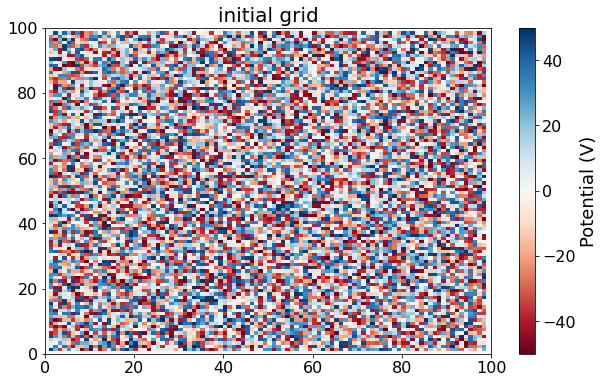

In [114]:
#define the size of our relaxation grid
rows = 100
columns = 100

#populate the grid, either with a uniform initial value or with random values
#(only one of the two lines below can be used at a time.)
#grid = np.ones([rows,columns])*25
grid = np.random.rand(rows,columns)*100-50

#set boundary conditions
grid[0,:] = 0
grid[:,0] = 0
grid[:,columns-1] = 0
grid[rows-1,:] = 0

#make a plot to show our initial conditions as a pixellated, colored contour map.
z_min, z_max = grid.min(), grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('initial grid' )
plt.savefig('100x100_initial_grid.jpg', bbox_inches='tight')    

Also define the geometry of the capacitor plates in this space that we want to model

In [121]:
#define the geometry of our capacitor plates
lower_plate = 30
upper_plate = 70
left_edge = 30
right_edge = 70

#create an array that is matched to the size of our grid, where we can 
#store information about the voltage we want to hold the capacitor's plates at
charges = np.zeros([rows,columns])
charges[lower_plate,left_edge:right_edge] = 100
charges[upper_plate,left_edge:right_edge] = -100

# Actually relax the grid



i:  50    error:  40.0
i:  100    error:  40.0
i:  150    error:  40.0
i:  200    error:  40.0
i:  250    error:  40.0
i:  300    error:  40.0
i:  350    error:  40.0
i:  400    error:  40.0
i:  450    error:  40.0
i:  500    error:  40.0


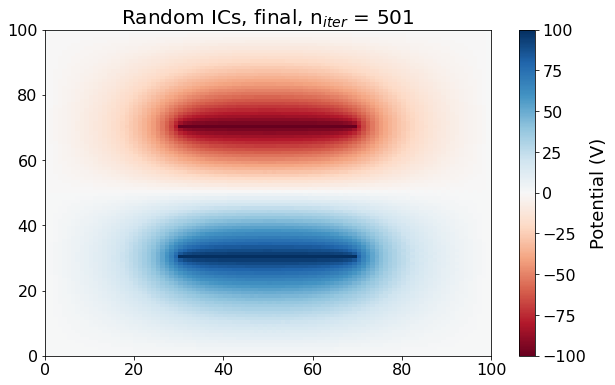

In [122]:
#save a copy of the input grid
initialGrid = np.copy(grid)

#perform the relaxation method
finalGrid, iterations = relaxGrid(grid, 0.4, limit = 500, charges = charges)

#plot the final grid
z_min, z_max = finalGrid.min(), finalGrid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
#print(np.flipud(finalGrid))
plt.savefig('100x100_final_grid.jpg', bbox_inches='tight')    

In [123]:
#find the electric field by locating the gradient in the potential
#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def findField(grid):
 
    xdimension = len(grid[0,:])
    ydimension = len(grid[:,0])
    
    X, Y = np.meshgrid(np.arange(0,xdimension,1),np.arange(0,ydimension,1))
    
    deltax = np.zeros([xdimension, ydimension])
    deltay = np.zeros([xdimension, ydimension])
        
    #use two loops to loop over rows and columns
    for i in range(1,xdimension-1):
        for j in range(1,ydimension-1):

            deltax[i,j] = -(grid[i,j+1] - grid[i,j-1])
            deltay[i,j] = -(grid[i+1,j] - grid[i-1,j])
 
    #print('loopy')

    return X, Y, deltax, deltay

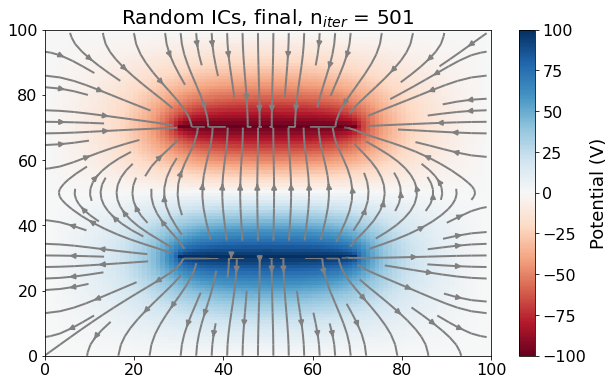

In [124]:
X, Y, ex, ey = findField(finalGrid)

#fig1 = plt.figure(figsize=(8, 8))
#ax1 = fig1.add_subplot(111)
#ax1.quiver(X, Y, ey, ex)
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.streamplot(X, Y, ex, ey, density=1, color = 'grey')
#print(np.flipud(finalGrid))
plt.savefig('100x100_final_grid_withField.jpg', bbox_inches='tight')    

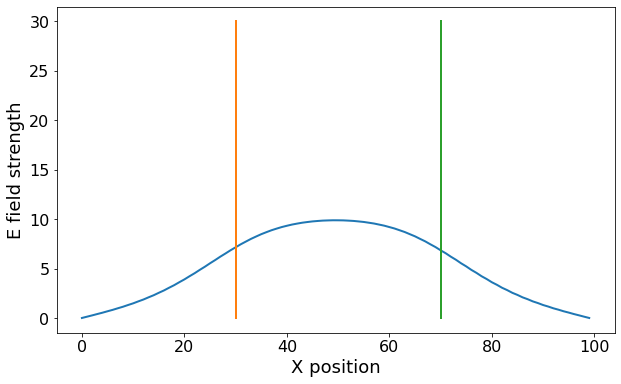

In [125]:
plt.plot(ey[50,:])
plt.plot([left_edge,left_edge], [0,30])
plt.plot([right_edge,right_edge], [0,30])
plt.xlabel('X position')
plt.ylabel('E field strength')
plt.show()

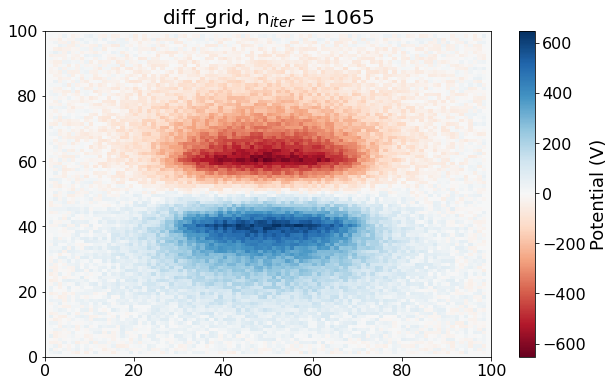

In [91]:
#determine how the grid evolved
diff_grid = finalGrid - initialGrid

#plot the difference grid.
z_min, z_max = diff_grid.min(), diff_grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), diff_grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('diff_grid, n$_{iter}$ = '+str(iterations) )
#print(np.flipud(finalGrid))
plt.savefig('100x100_diff_plaid.jpg', bbox_inches='tight')    